# Imports

In [1]:
import sys

sys.path.append("..")
import numpy as np
import plotly.express as px
import plotly.io as pio
from ipywidgets import interact
from scipy.optimize import root_scalar

from calibration.projector.board import draw_board
from calibration.projector.projector import Projector

pio.renderers.default = "svg"

In [2]:
proj = Projector()

# Backprojection

In [3]:
w, h = proj.camera.resolution
w, h

(1200, 800)

## Image plane

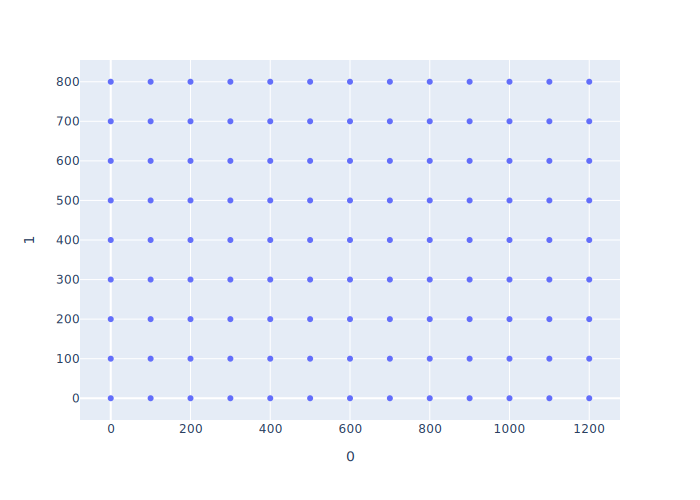

In [4]:
# xs = [[0, 0], [w, 0], [w, h], [0, h]]
xs = [np.array([x, y, 1]) for x in range(0, w + 1, 100) for y in range(0, h + 1, 100)]
xs = np.array(xs)
px.scatter(xs, x=0, y=1)

## Intrinsic

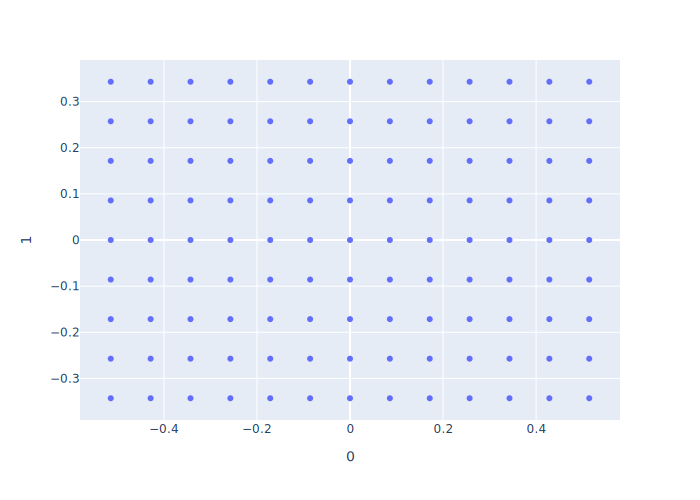

In [5]:
# xs1 = [np.linalg.inv(proj.camera.intrinsic_matrix) @ x for x in xs]
xs1 = (np.linalg.inv(proj.camera.intrinsic_matrix) @ xs.T).T
# xs1 = np.array(xs1)
np.testing.assert_equal(xs1[:, 2], 1)
px.scatter(xs1, x=0, y=1)

## Distortion

In [30]:
def f(l1, l2):
    projector = Projector(lambdas=np.array([l1, l2]))
    xs2 = xs1.copy()
    rs = projector.psi(np.linalg.norm(xs2[:, :2], axis=1))
    xs2[:, 2] = rs
    xs2 /= xs2[:, 2][:, np.newaxis]
    return draw_board(xs2)

In [32]:
# interact(f, l1=(-5.0, 5.0), l2=(-10, 10, 0.001));

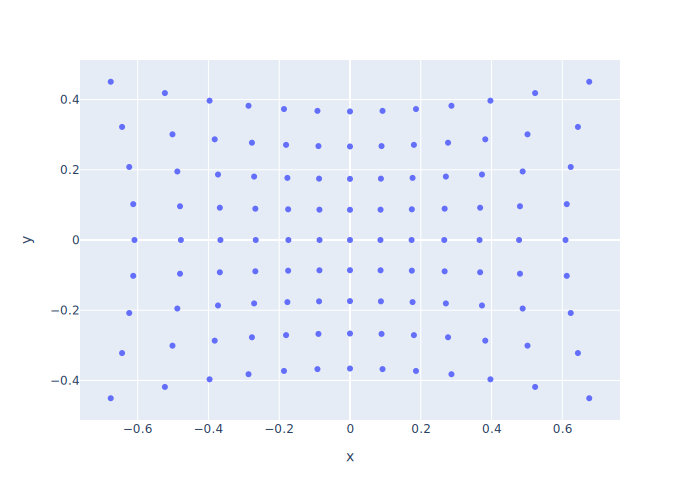

In [37]:
lambdas = np.array([-0.5, -0.33])

projector = Projector(lambdas=lambdas)
xs2 = xs1.copy()
psis = projector.psi(np.linalg.norm(xs2[:, :2], axis=1))
xs2[:, 2] = psis
xs2 /= xs2[:, 2][:, np.newaxis]
draw_board(xs2)

## Extrinsics

In [9]:
def f(t1, t2, t3):
    R = np.eye(3)
    t = np.array([t1, t2, t3])
    P = np.c_[R[:, :2], t]
    xs3 = xs2.copy()
    xs3 = (P @ xs3.T).T
    xs3 /= xs3[:, 2][:, np.newaxis]
    return draw_board(xs3)

In [10]:
interact(f, t1=(-5.0, 5.0), t2=(-5.0, 5.0), t3=(-5.0, 0.01));

interactive(children=(FloatSlider(value=0.0, description='t1', max=5.0, min=-5.0), FloatSlider(value=0.0, desc…

In [11]:
R = np.eye(3)
t = [-0.1, -0.1, -2]

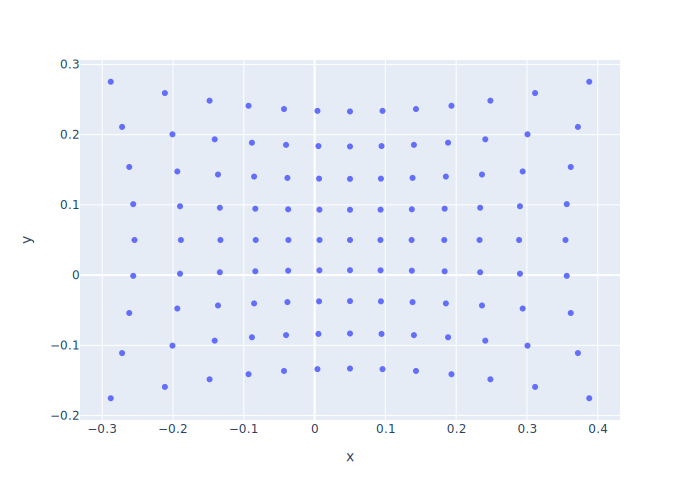

In [12]:
xs3 = xs2.copy()
P = np.c_[R[:, :2], t]
xs3 = (P @ xs3.T).T
xs3 /= xs3[:, 2][:, np.newaxis]

draw_board(xs3)

# Projection

## Extrinsics

In [13]:
xs3_ = xs3.copy()

In [14]:
xs2_ = xs3_.copy()
xs2_ = (np.linalg.inv(P) @ xs2_.T).T
xs2_ /= xs2_[:, 2][:, np.newaxis]

np.testing.assert_array_almost_equal(xs2, xs2_)
# draw_board(xs2_)

## Distortion

In [42]:
def f(r, x):
    # x[2] == 1
    return proj.psi(r) * np.linalg.norm(x[:2]) - r


max_point_img_space = np.r_[proj.camera.resolution, 1]
max_point = np.linalg.inv(proj.camera.intrinsic_matrix) @ max_point_img_space
max_r = np.linalg.norm(max_point) / 2

In [57]:
xs1_ = xs2_.copy()
assert (xs1_[:, 2] == 1).all()
idx = np.linalg.norm(xs1_[:, :2], axis=1) > 0

rs_ = np.array(
    [root_scalar(f, args=(xi,), bracket=(0, max_r)).root for xi in xs1_[idx]]
)
xs1_[idx] *= proj.psi(rs_)[:, np.newaxis]
# xs1_[idx] *= (rs_ /  np.linalg.norm(xs1_[:, :2], axis=1)[idx])[:, np.newaxis]
xs1_[:, 2] = 1

np.testing.assert_array_almost_equal(xs1, xs1_)

AssertionError: 
Arrays are not almost equal to 6 decimals

Mismatched elements: 212 / 351 (60.4%)
Max absolute difference: 0.09341566
Max relative difference: 0.22195845
 x: array([[-0.514286, -0.342857,  1.      ],
       [-0.514286, -0.257143,  1.      ],
       [-0.514286, -0.171429,  1.      ],...
 y: array([[-0.42087 , -0.28058 ,  1.      ],
       [-0.43578 , -0.21789 ,  1.      ],
       [-0.447438, -0.149146,  1.      ],...

In [63]:
np.linalg.norm(xs1_[:, :2]) - rs_

array([3.38345873, 3.40206493, 3.41764029, 3.42816762, 3.43190891,
       3.42816762, 3.41764029, 3.40206493, 3.38345873, 3.41434245,
       3.43978259, 3.46216127, 3.47787799, 3.48358118, 3.47787799,
       3.46216127, 3.43978259, 3.41434245, 3.4482332 , 3.48358118,
       3.51640981, 3.54041914, 3.54932001, 3.54041914, 3.51640981,
       3.48358118, 3.4482332 , 3.48358118, 3.5319903 , 3.57926802,
       3.61518508, 3.6288102 , 3.61518508, 3.57926802, 3.5319903 ,
       3.48358118, 3.51640981, 3.57926802, 3.64342895, 3.69497777,
       3.71573611, 3.69497777, 3.64342895, 3.57926802, 3.51640981,
       3.54041914, 3.61518508, 3.69497777, 3.76715811, 3.80322072,
       3.76715811, 3.69497777, 3.61518508, 3.54041914, 3.54932001,
       3.6288102 , 3.71573611, 3.80322072, 3.80322072, 3.71573611,
       3.6288102 , 3.54932001, 3.54041914, 3.61518508, 3.69497777,
       3.76715811, 3.80322072, 3.76715811, 3.69497777, 3.61518508,
       3.54041914, 3.51640981, 3.57926802, 3.64342895, 3.69497

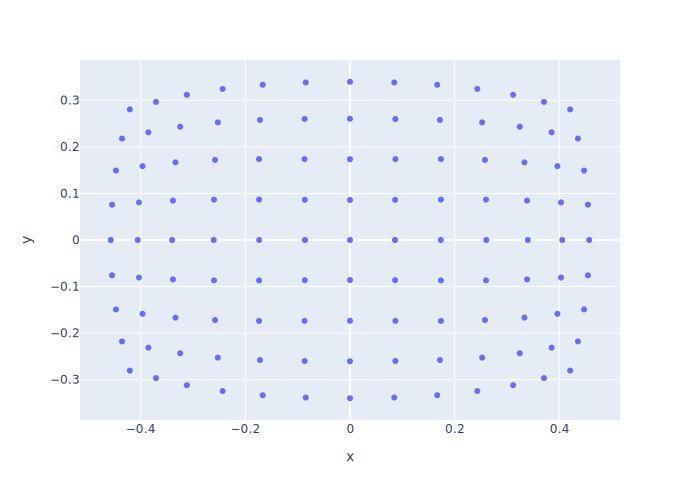

In [58]:
draw_board(xs1_)

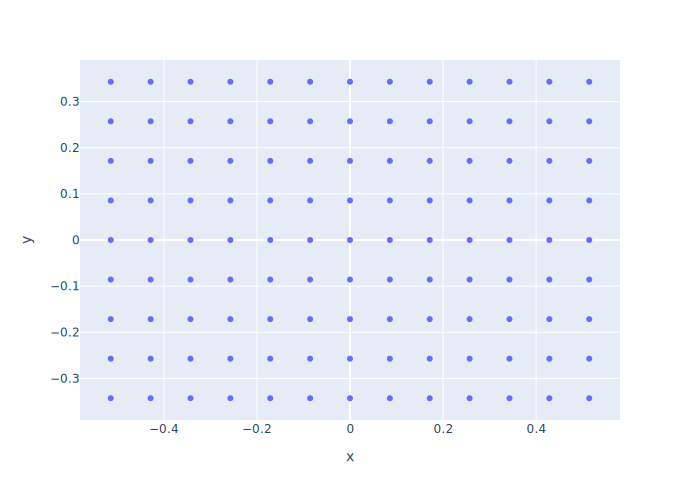

In [51]:
draw_board(xs1)

In [ ]:
np.linalg.norm(xs2[:, :2], axis=1)